In [108]:
%matplotlib inline
from os import listdir
from os.path import expanduser, join
from collections import defaultdict
from HTMLParser import HTMLParser

# These are files downloaded for each year with "Export to Excel" from https://sfgov.legistar.com/DepartmentDetail.aspx?ID=7374&GUID=978C35A3-7173-49E6-8FAA-8EA34A7D4160&Mode=MainBody
# It turns out that that actually exports to HTML, so I renamed the files.
RAW_DATA_DIR = expanduser("sf-bos/data")

class RollCallParser(HTMLParser):
    def __init__(self, *args, **kwargs):
        HTMLParser.__init__(self, *args, **kwargs)
        self.inHeader = False
        self.inBody = False
        self.cellTag = ""
        
        self.partialText = ""
        self.headerRow = []
        self.currentRow = []
        self.rawData = []
        
    def handle_starttag(self, tag, attrs):
        if tag == "thead":
            self.inBody = False
            self.inHeader = True
            self.cellTag = "th"
        if tag == "tbody":
            self.inHeader = False
            self.inBody = True
            self.cellTag = "td"
        if tag == "tr":
            self.currentRow = []
        elif tag == self.cellTag:
            self.partialText = ""

    def handle_endtag(self, tag):
        if not self.inHeader and not self.inBody:
            return
        if tag == self.cellTag:
            cell = self.partialText.replace("&nbsp;", " ").strip()
            self.currentRow.append(cell)
        elif tag == "tr":
            if not self.currentRow:
                return
            if self.inHeader:
                self.headerRow = self.currentRow
            else:
                self.rawData.append(dict(zip(self.headerRow, self.currentRow)))

    def handle_data(self, data):
        self.partialText += data
            
    def drop_unanimous(self):
        def is_unanimous(row):
            ayes, nays = map(int, row.get("Tally").split(":"))
            return ayes == 0 or nays == 0
        self.rawData = filter(lambda r: not is_unanimous(r), self.rawData)
            

ALL_VOTE_KEYS = set()
VOTES_BY_BILL = defaultdict(dict)
ALL_SUPERVISORS = set()

for fname in sorted(listdir(RAW_DATA_DIR)):
    if fname.startswith("BOS") and fname.endswith(".html"):
        parser = RollCallParser()
        with open(join(RAW_DATA_DIR, fname)) as fin:
                for line in fin:
                    parser.feed(line)
                parser.close()
        votes = len(parser.rawData)
        parser.drop_unanimous()
        print "%s - %d votes, %d non-unanimous" % (fname, votes, len(parser.rawData))
        KNOWN_KEYS = ("File#", "ActionDate", "Title", "Tally")
        for row in parser.rawData:
            try:
                voteKey = (row["File#"], row["ActionDate"], row["Title"])
            except Exception as e:print row, parser.headerRow, repr(e)
            ALL_VOTE_KEYS.add(voteKey)
            for key, value in row.items():
                if key in KNOWN_KEYS:
                    continue
                # Otherwise, it's a (supervisor, vote) pair
                if value not in ("Vacant", "N/A"):
                    VOTES_BY_BILL[voteKey][key] = value
                    ALL_SUPERVISORS.add(key)

print "There are %d votes on %d motions" % (sum(len(vs) for vs in VOTES_BY_BILL.values()), len(VOTES_BY_BILL))

BOS-1998.html - 1298 votes, 48 non-unanimous
BOS-1999.html - 3572 votes, 101 non-unanimous
BOS-2000.html - 3407 votes, 125 non-unanimous
BOS-2001.html - 2967 votes, 209 non-unanimous
BOS-2002.html - 2787 votes, 321 non-unanimous
BOS-2003.html - 2687 votes, 280 non-unanimous
BOS-2004.html - 2641 votes, 266 non-unanimous
BOS-2005.html - 2924 votes, 180 non-unanimous
BOS-2006.html - 2545 votes, 167 non-unanimous
BOS-2007.html - 2465 votes, 267 non-unanimous
BOS-2008.html - 2403 votes, 317 non-unanimous
BOS-2009.html - 1972 votes, 227 non-unanimous
BOS-2010.html - 1812 votes, 210 non-unanimous
BOS-2011.html - 1573 votes, 135 non-unanimous
BOS-2012.html - 1436 votes, 102 non-unanimous
BOS-2013.html - 1379 votes, 59 non-unanimous
BOS-2014.html - 1516 votes, 91 non-unanimous
BOS-2015.html - 1461 votes, 85 non-unanimous
BOS-2016.html - 1028 votes, 75 non-unanimous
BOS-2017.html - 1547 votes, 91 non-unanimous
BOS-2018.html - 1536 votes, 54 non-unanimous
There are 34277 votes on 3119 motions


In [109]:
# Filter out the unanimous votes

AYES_BY_BILL = defaultdict(set)
NOES_BY_BILL = defaultdict(set)
MISSED_VOTES = defaultdict(set)

for key, votes in VOTES_BY_BILL.items():
    for supervisor, v in votes.items():
        if v == "Aye":
            AYES_BY_BILL[key].add(supervisor)
        elif v == "No":
            NOES_BY_BILL[key].add(supervisor)
        elif v in ("Absent", "Abstain", "Excused", "N/A", "Vacant"):
            MISSED_VOTES[key].add(supervisor)
        else:
            print "What kind of a vote is", v

NON_UNANIMOUS_VOTES = set()
for key in ALL_VOTE_KEYS:
    if len(AYES_BY_BILL[key]) == 0 or len(NOES_BY_BILL[key]) == 0:
        continue
    NON_UNANIMOUS_VOTES.add(key)
print "There were %d non-unanimous votes" % len(NON_UNANIMOUS_VOTES)

There were 3119 non-unanimous votes


In [110]:
# How many times was a given supervisor the only dissenter?
lone_dissents = defaultdict(int)
for v in ALL_VOTE_KEYS:
    if len(AYES_BY_BILL[v]) == 1:
        lone_dissents[list(AYES_BY_BILL[v])[0]] += 1
    if len(NOES_BY_BILL[v]) == 1:
        lone_dissents[list(AYES_BY_BILL[v])[0]] += 1

for s, dissents in lone_dissents.items():
    print dissents, "\t", s
    

39 	Jeff Sheehy
117 	Jane Kim
142 	John Avalos
7 	David Campos
218 	Mark Leno
208 	Gerardo Sandoval
13 	Vallie Brown
7 	Matt Gonzalez
16 	Gavin Newsom
4 	Chris Daly
1 	Barbara Kaufman
1 	Tony Hall
344 	Ross Mirkarimi
3 	Tom Ammiano
2 	Malia Cohen
2 	Sean Elsbernd
43 	Mabel Teng


In [238]:
# Export to CSV to import into R (rpy2 doesn't work on my system)
import csv, tempfile, time
from shutil import rmtree
from os.path import join
import subprocess as sp

def export_to_csv(fname, votes, start_year=None, min_votes_per_term=0):
    if start_year is None:
        start_year = min(int(date.split("/")[-1]) for (_, date, _) in votes.keys())
        
    votes_by_year = defaultdict(lambda: defaultdict(int))
    for (fno, date, title), vs in votes.items():
        year = int(date.split("/")[-1])
        if year < start_year:
            continue
        for s, v in vs.items():
            if v in ("Aye", "No"):
                votes_by_year[year][s] += 1

    drop_supes = defaultdict(set)
    for y, vs in votes_by_year.items():
        most_votes = max(vs.values())
        for s, c in vs.items():
            if float(c) / most_votes < min_votes_per_term:
                drop_supes[y].add(s)
    if drop_supes:
        print "Dropping supervisors", drop_supes
        
        
    filtered_votes = []
    filtered_supes = set()
    for (fno, date, title), vs in votes.items():
        year = int(date.split("/")[-1])
        if year < start_year:
            continue
        row = {"term": year - start_year + 1}
        for s, v in vs.items():
            if s in drop_supes[year]:
                continue
            s = s.replace(" ", "").replace(".", "").replace("-", "")
            if v == "Aye":
                row[s] = 1
                filtered_supes.add(s)
            elif v == "No":
                row[s] = 0
                filtered_supes.add(s)
        if len(row) > 1:
            filtered_votes.append(row)

    filtered_supes = list(sorted(filtered_supes))
    header = filtered_supes + ["term"]
    with open(fname, "wb") as fout:
        writer = csv.writer(fout)
        writer.writerow(header)
        for row in filtered_votes:
            writer.writerow([row.get(k, "NA") for k in header])
    return filtered_supes

def run_r(temp_csv, filtered_supes, command):
    progs = [s for s in filtered_supes if s in ("AaronPeskin", "ChrisDaly", "JohnAvalos", "DavidCampos", "EricMar", "HillaryRonen", "JaneKim")]
    mods =  [s for s in filtered_supes if s in ("CarmenChu", "DavidChiu", "ScottWiener", "KatyTang", "LondonNBreed", "MaliaCohen", "MarkFarrell", "MichelaAliotoPier")]

    filters = []
    constraints = []
    for p in progs:
        idx = filtered_supes.index(p) + 1
        filters.append("theta.start[%d] = -1  # %s" % (idx, p))
        constraints.append('%s="-"' % p)
    for m in mods:
        idx = filtered_supes.index(m) + 1
        filters.append("theta.start[%d] = 1   # %s" % (idx, m))
        constraints.append('%s="+"' % p)
    
    r_program = ("""
library(MCMCpack)

BoardOfSupervisors <- read.csv(file="%(fname)s", header=TRUE, sep=",")

theta.start = rep(0, %(n_supes)2d)
%(filters)s

out <- """ + command + """

summary(out)
""") % {
    "fname": temp_csv,
    "n_supes": len(filtered_supes),
    "filters": "\n".join(filters),
    "constraints": ",".join(constraints),
}
    r_src = join(scratch_dir, "program.R")
    with open(r_src, "w") as fout:
        print >>fout, r_program

    start = time.time()
    print "Starting R run..."
    output = sp.check_output(["Rscript", r_src])
    print "---------", int(time.time() - start), "seconds", "---------"
    return output


In [239]:
## WARNING -- This can take several hours to run, depending on how far back you go

scratch_dir = tempfile.mkdtemp()
temp_csv = join(scratch_dir, "votes.csv")
filtered_supes = export_to_csv(temp_csv, VOTES_BY_BILL, start_year=2011, min_votes_per_term=.3)
cmd_1d_dyn = """
MCMCdynamicIRT1d(t(BoardOfSupervisors[,1:%(n_supes)d]),
                            item.time.map=BoardOfSupervisors$term,
                            mcmc=20000,
                            burnin=5000,
                            thin=5,
                            verbose=500,
                            tau2.start=rep(0.1, %(n_supes)d),
                            e0=0, E0=1,
                            a0=0, A0=1,
                            b0=0, B0=1,
                            c0=-1, d0=-1,
                            store.item=FALSE,
                            theta.constraints=list(%(constraints)s))
"""
output_1d_dyn = run_r(temp_csv, filtered_supes, cmd_1d_dyn)

rmtree(scratch_dir)

Dropping supervisors defaultdict(<type 'set'>, {2018: set(['Mark Farrell']), 2011: set(['Michela Alioto-Pier', 'Sophie Maxwell', 'Chris Daly', 'Bevan Dufty']), 2013: set(['Carmen Chu']), 2015: set(['Aaron Peskin'])})
Starting R run...
--------- 1200 seconds ---------


In [215]:
scratch_dir = tempfile.mkdtemp()
temp_csv = join(scratch_dir, "votes.csv")
filtered_supes = export_to_csv(temp_csv, VOTES_BY_BILL, start_year=2011)
cmd_1d_static = """
MCMCirt1d(t(BoardOfSupervisors[,1:%(n_supes)d]),
                    theta.constraints=list(JohnAvalos="-", JaneKim="-", KatyTang="+", CarmenChu="+"),
                    B0.alpha=.2,
                    B0.beta=.2,
                    burnin=500,
                    mcmc=100000,
                    thin=20,
                    verbose=500,
                    store.item=TRUE)
"""

output_1d_static = run_r(temp_csv, filtered_supes, cmd_1d_static)

rmtree(scratch_dir)

Starting R run...
--------- 185 seconds ---------


In [299]:
scratch_dir = tempfile.mkdtemp()
temp_csv = join(scratch_dir, "votes.csv")
filtered_supes = export_to_csv(temp_csv, VOTES_BY_BILL, start_year=2011, min_votes_per_term=.1)
cmd_2d = """
MCMCirtKd(t(BoardOfSupervisors[,1:%(n_supes)d]), dimensions=2,
                    burnin=5000, verbose=500,
                    mcmc=10000, thin=10,
                    B0=.25, store.item=TRUE)
"""

output_2d = run_r(temp_csv, filtered_supes, cmd_2d)

rmtree(scratch_dir)

Dropping supervisors defaultdict(<type 'set'>, {2018: set(['Mark Farrell']), 2011: set(['Michela Alioto-Pier', 'Sophie Maxwell', 'Chris Daly', 'Bevan Dufty']), 2013: set(['Carmen Chu']), 2015: set(['Aaron Peskin'])})
Starting R run...
--------- 173 seconds ---------


In [382]:
scratch_dir = tempfile.mkdtemp()
temp_csv = join(scratch_dir, "votes.csv")
filtered_supes = export_to_csv(temp_csv, VOTES_BY_BILL, start_year=2011, min_votes_per_term=.1)
cmd_3d = """
MCMCirtKd(t(BoardOfSupervisors[,1:%(n_supes)d]), dimensions=3,
                    burnin=5000, verbose=500,
                    mcmc=10000, thin=10,
                    B0=.25, store.item=TRUE)
"""

output_3d = run_r(temp_csv, filtered_supes, cmd_3d)

rmtree(scratch_dir)

Dropping supervisors defaultdict(<type 'set'>, {2018: set(['Mark Farrell']), 2011: set(['Michela Alioto-Pier', 'Sophie Maxwell', 'Chris Daly', 'Bevan Dufty']), 2013: set(['Carmen Chu']), 2015: set(['Aaron Peskin'])})
Starting R run...
--------- 145 seconds ---------


In [286]:
from collections import defaultdict

idx = {
    "mean": 0,
    "std": 1,
    "naive_se": 2,
    "tsse": 3,
    "pct_2.5": 4,
    "pct_25": 5,
    "pct_50": 6,
    "pct_75": 7,
    "pct_97.5": 8,
}

def parse_output(output, terms=False, dims=1, start_year=None):
    ds = defaultdict(dict)
    header = []
    end_year = 0
    for line in output.splitlines():
        if "Empirical" in line:
            ds = defaultdict(dict)
            header = ["mean", "std", "naive_se", "tsse"]
        elif "Quantiles" in line:
            header = ["pct_2.5", "pct_25", "pct_50", "pct_75", "pct_97.5"]
        elif line.startswith("theta."):
            tokens = line.split()
            key = tokens[0].split(".", 1)[-1] # Remove the "theta."
            vals = map(float, tokens[1:])
            for k, v in zip(header, vals):
                ds[key][k] = v
            if terms:
                y = int(key.rsplit(".", 1)[-1][1:]) + start_year
                end_year = max(end_year, y)
    
    # Get all the names used in this batch of data
    names = set()
    for k in ds.keys():
        names.add(k.split(".")[0])
    names = dict((n, i) for i, n in enumerate(sorted(names)))
    
    rows = dims
    if terms:
        rows = end_year - start_year + 1
    irt_data = np.full((rows, len(names), 9), np.nan)
    for k, vs in ds.items():
        if "." in k:
            name, row = k.rsplit(".", 1)
        else:
            name = k
            row = ""
        if row:
            if "t" in row:
                row = row[1:]
            row = int(row) - 1
        else:
            row = 0

        for col in ("mean", "std", "naive_se", "tsse", "pct_2.5", "pct_25", "pct_50", "pct_75", "pct_97.5"):
            irt_data[row, names[name], idx[col]] = vs[col]
    return names, irt_data



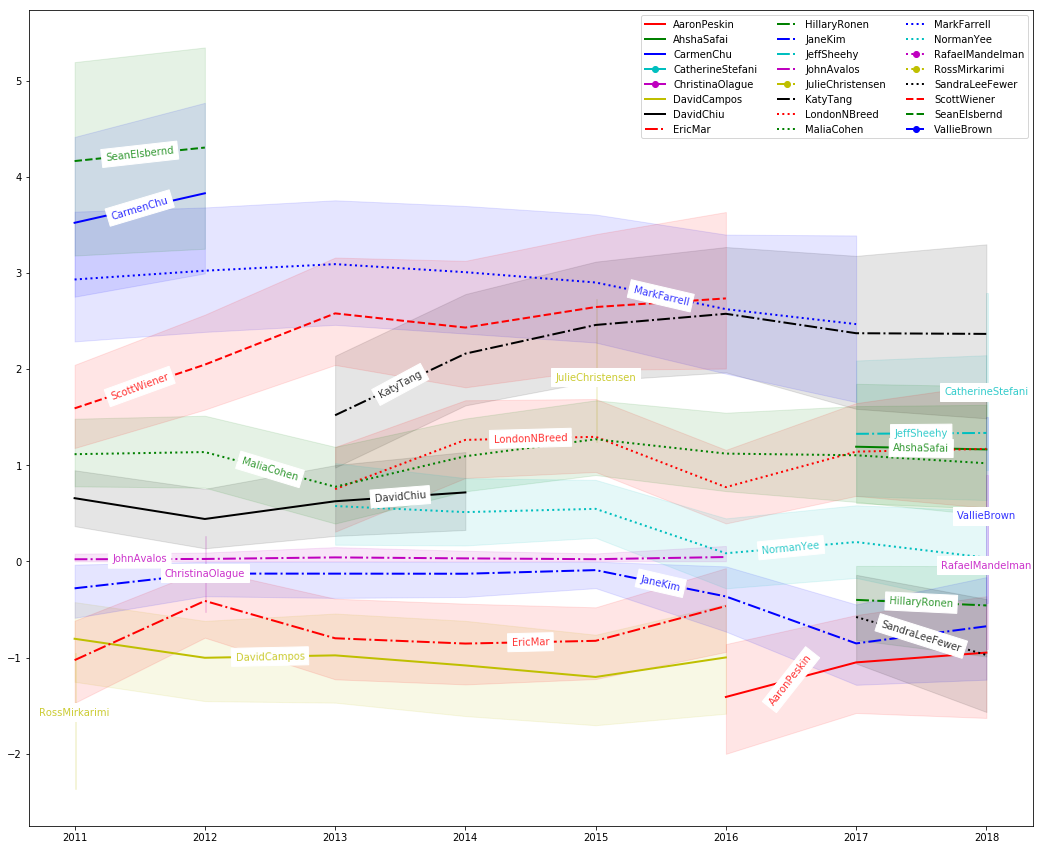

In [356]:
%matplotlib inline
import numpy as np
import random
from itertools import product, cycle, izip
from matplotlib import pyplot as plt
from labellines import labelLine, labelLines

start_year = 2011
names, dynData = parse_output(output_1d_dyn, start_year=start_year, terms=True)
terms = np.arange(start_year, start_year + dynData.shape[0])

"""
cc = names["CarmenChu"]
kt = names["KatyTang"]
jk = names["JaneKim"]

print "CC", dynData[5:,cc,idx["mean"]]
print "KT", dynData[5:,kt,idx["mean"]]
print "JK", dynData[5:,jk,idx["mean"]]


for t in range(len(terms)):
    if np.isnan(dynData[t,kt,idx["mean"]]) or np.isnan(dynData[t,jk,idx["mean"]]):
        continue
    print dynData[t,kt,idx["mean"]], dynData[t,jk,idx["mean"]], dynData[t,cc,idx["mean"]]
    continue
    if dynData[t,kt,idx["mean"]] < dynData[t,jk,idx["mean"]]:
        print "flipping", t
        # Flip the axes
        for n, i in names.items():
            dynData[t,i,idx["mean"]] *= -1
            dynData[t,i,idx["pct_2.5"]] = dynData[t,i,idx["pct_97.5"]] * -1
            dynData[t,i,idx["pct_25"]] = dynData[t,i,idx["pct_75"]] * -1
            dynData[t,i,idx["pct_50"]] = dynData[t,i,idx["pct_50"]] * -1
            
print "CC", dynData[5:,cc,idx["mean"]]
print "KT", dynData[5:,kt,idx["mean"]]
print "JK", dynData[5:,jk,idx["mean"]]
"""


plt.figure(figsize=(18,15))
styles = [c+l for l, c in product(("-", "-.", ":", "--"), "rgbcmyk")]

# First the dynamic data
labelcounts = defaultdict(int)
for (n, i), style in izip(sorted(names.items()), cycle(styles)):
    Xs = terms
    Ys = dynData[:,i,idx["mean"]]
    El = dynData[:,i,idx["pct_2.5"]]
    Eh = dynData[:,i,idx["pct_97.5"]]
    notnan = ~np.isnan(dynData[:,i,idx["mean"]])

    if np.count_nonzero(notnan) == 1:
        style += "o"
        Xs = Xs[notnan]
        Xs = np.append(Xs, Xs[0] + 0.01)
        Ys = Ys[notnan]
        Ys = np.append(Ys, Ys[0])

        El = El[notnan]
        El = np.append(El, El[0])
        Eh = Eh[notnan]
        Eh = np.append(Eh, Eh[0])
    elif np.count_nonzero(~np.isnan(dynData[:,i,idx["mean"]])) == 0:
        continue

    line = plt.plot(Xs, Ys, style, label=n, linewidth=2)
    if max(Xs) - min(Xs) < 1:
        lloc = min(Xs)
    else:
        locs = [x - 0.5 for i, x in enumerate(Xs) if not np.isnan(Ys[i])][1:]
        lloc = min(locs, key=lambda l: labelcounts[l])
    labelcounts[lloc] += 1
    labelLine(line[0], lloc, label=n, alpha=0.8)
    plt.fill_between(Xs, El, Eh, color=style[0], alpha=0.1)

plt.legend(loc="upper right", ncol=3)
plt.show()



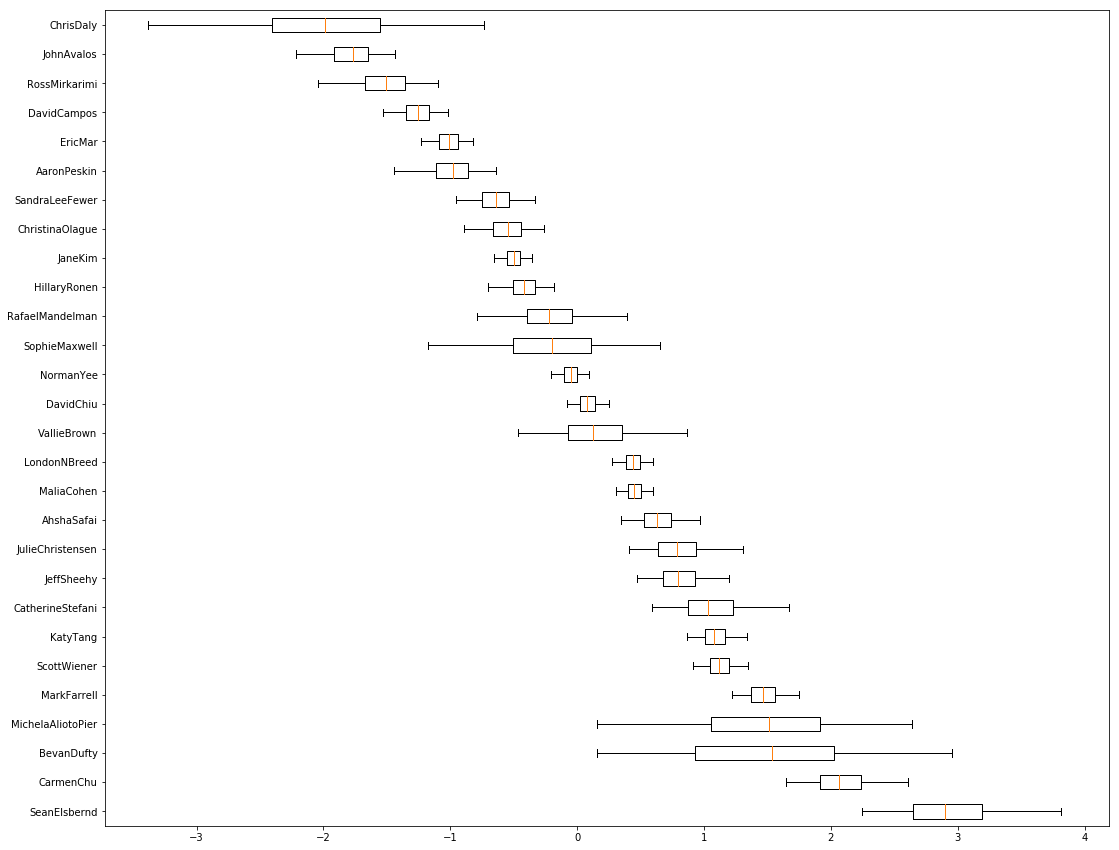

In [347]:
# Then, the static data

# Straight from StackOverflow:
# https://stackoverflow.com/questions/27214537/is-it-possible-to-draw-a-matplotlib-boxplot-given-the-percentile-values-instead
def customized_box_plot(percentiles, axes, redraw = True, *args, **kwargs):
    """
    Generates a customized boxplot based on the given percentile values
    """
    n_box = len(percentiles)
    box_plot = axes.boxplot([[-9, -4, 2, 4, 9],]*n_box, *args, **kwargs) 
    # Creates len(percentiles) no of box plots

    min_y, max_y = float('inf'), -float('inf')

    for box_no, pdata in enumerate(percentiles):
        if len(pdata) == 6:
            (q1_start, q2_start, q3_start, q4_start, q4_end, fliers_xy) = pdata
        elif len(pdata) == 5:
            (q1_start, q2_start, q3_start, q4_start, q4_end) = pdata
            fliers_xy = None
        else:
            raise ValueError("Percentile arrays for customized_box_plot must have either 5 or 6 values")

        # Lower cap
        box_plot['caps'][2*box_no].set_xdata([q1_start, q1_start])
        # xdata is determined by the width of the box plot

        # Lower whiskers
        box_plot['whiskers'][2*box_no].set_xdata([q1_start, q2_start])

        # Higher cap
        box_plot['caps'][2*box_no + 1].set_xdata([q4_end, q4_end])

        # Higher whiskers
        box_plot['whiskers'][2*box_no + 1].set_xdata([q4_start, q4_end])

        # Box
        path = box_plot['boxes'][box_no].get_path()
        path.vertices[0][0] = q2_start
        path.vertices[1][0] = q2_start
        path.vertices[2][0] = q4_start
        path.vertices[3][0] = q4_start
        path.vertices[4][0] = q2_start

        # Median
        box_plot['medians'][box_no].set_xdata([q3_start, q3_start])

        # Outliers
        if fliers_xy is not None and len(fliers_xy[0]) != 0:
            # If outliers exist
            box_plot['fliers'][box_no].set(xdata = fliers_xy[0],
                                           ydata = fliers_xy[1])

            min_y = min(q1_start, min_y, fliers_xy[1].min())
            max_y = max(q4_end, max_y, fliers_xy[1].max())

        else:
            min_y = min(q1_start, min_y)
            max_y = max(q4_end, max_y)

        # The y axis is rescaled to fit the new box plot completely with 10% 
        # of the maximum value at both ends
        axes.set_xlim([min_y*1.1, max_y*1.1])

    # If redraw is set to true, the canvas is updated.
    if redraw:
        ax.figure.canvas.draw()

    return box_plot

names, data = parse_output(output_1d_static, start_year=2011)

pctiles = []
labels = []
for n, i in sorted(names.items(), key=lambda (n,i): -data[0,i,idx["mean"]]):
    row = [data[0,i,idx[k]] for k in ("pct_2.5", "pct_25", "pct_50", "pct_75", "pct_97.5")]
    pctiles.append(row)
    labels.append(n)
    
plt.figure(figsize=(18, 15))
ax = plt.axes()
customized_box_plot(pctiles, ax, vert=False, labels = labels)

plt.show()

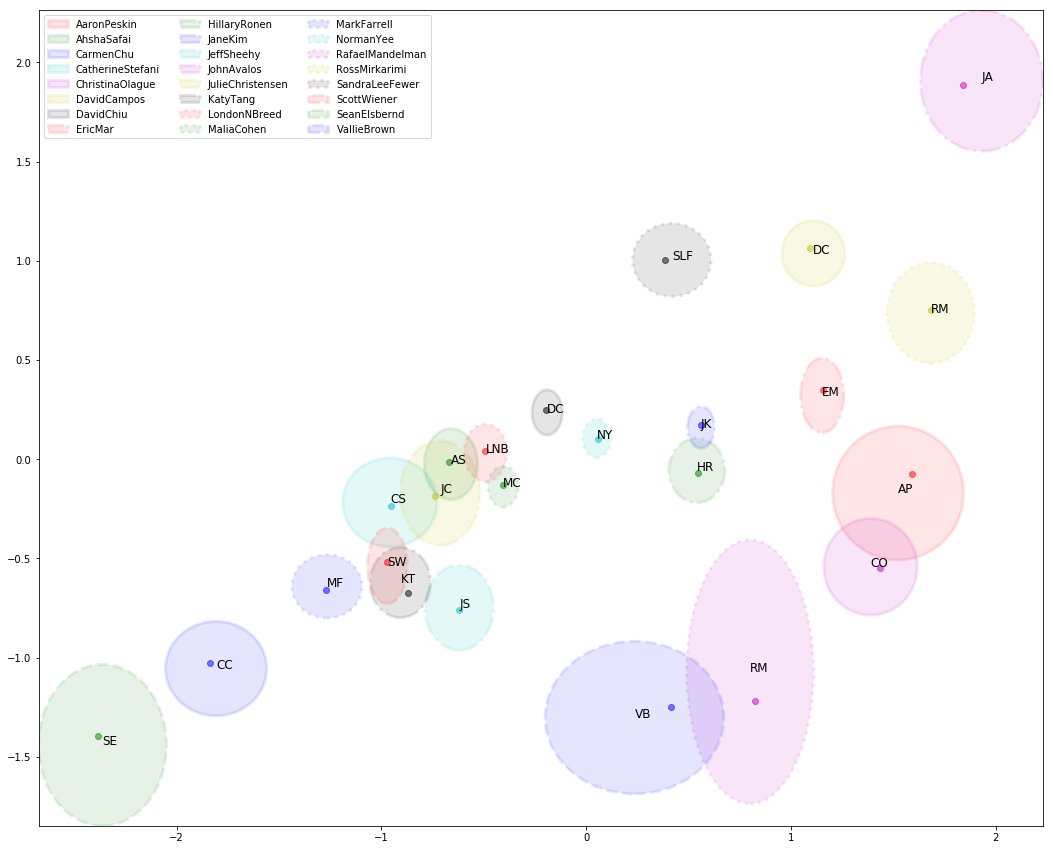

In [424]:
# Finally, the 2d data
from matplotlib.patches import Ellipse

names, data = parse_output(output_2d, start_year=2011, dims=2)

plt.figure(figsize=(18, 15))
ax = plt.axes()
patches = []
xmin = 0
xmax = 0
ymin = 0
ymax = 0
for (n, i), style in izip(sorted(names.items()), cycle(styles)):
    x = data[0, i, idx["pct_50"]]
    y = data[1, i, idx["pct_50"]]
    if np.isnan(x) or np.isnan(y):
        continue
    # Not actually the right way to plot this, but it's a quick approximation
    iqr_w = max(abs(x - data[0, i, idx["pct_25"]]), abs(x - data[0, i, idx["pct_75"]]))
    iqr_h = max(abs(y - data[1, i, idx["pct_25"]]), abs(y - data[1, i, idx["pct_75"]]))
    c, ls = style[0], style[1:]
    e = Ellipse(xy=(x, y), width=iqr_w*2, height=iqr_h*2, color=c, linestyle=ls, linewidth=3, alpha=.1, label=n)
    
    xmax = max(xmax, x + iqr_w)
    xmin = min(xmin, x - iqr_w)
    ymax = max(ymax, y + iqr_h)
    ymin = min(ymin, y - iqr_h)

    patches.append(e)
    ax.add_artist(e)
        
    # Alternative: plot medians and error bars; more accurate but harder to interpret and more messy
    #plt.plot([x], [y], color=c, marker='o', alpha=.5)
    #plt.plot([data[0, i, idx["pct_25"]], data[0, i, idx["pct_75"]]], [y, y])
    #plt.plot([x,x], [data[1, i, idx["pct_25"]], data[1, i, idx["pct_75"]]])
    
    
    plt.plot([data[0, i, idx["mean"]]], data[1, i, idx["mean"]], color=c, marker='o', alpha=.5)
    s = "".join(c for c in n if c.isupper())
    #s = n
    plt.text(x, y, s, fontsize=12)
    
plt.legend(loc='upper left', ncol=3, handles=patches)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()
    
    

In [426]:
# Experiment: the 3d data
from mpl_toolkits.mplot3d import Axes3D

names, data = parse_output(output_3d, start_year=2011, dims=3)

plt.figure(figsize=(18, 15), dpi=100)
ax = fig.add_subplot(111, projection='3d')

patches = []
xmin = float("inf")
xmax = float("-inf")
ymin = float("inf")
ymax = float("-inf")
zmin = float("inf")
zmax = float("-inf")

for (n, i), style in izip(sorted(names.items()), cycle(styles)):
    x = data[0, i, idx["pct_50"]]
    y = data[1, i, idx["pct_50"]]
    z = data[2, i, idx["pct_50"]]

    if np.isnan(x) or np.isnan(y) or np.isnan(z):
        continue
        
    row = [n] + ["%6.2f" % v for v in (x, y, z)]
    print ",".join(row)
        
    # Not actually the right way to plot this, but it's a quick approximation
    iqr_w = max(abs(x - data[0, i, idx["pct_25"]]), abs(x - data[0, i, idx["pct_75"]]))
    iqr_h = max(abs(y - data[1, i, idx["pct_25"]]), abs(y - data[1, i, idx["pct_75"]]))
    iqr_d = max(abs(z - data[2, i, idx["pct_25"]]), abs(z - data[2, i, idx["pct_75"]]))
    
    xmax = max(xmax, x + iqr_w)
    xmin = min(xmin, x - iqr_w)
    ymax = max(ymax, y + iqr_h)
    ymin = min(ymin, y - iqr_h)
    zmax = max(zmax, z + iqr_d)
    zmin = min(zmin, z - iqr_d)

    xmean = [data[0, i, idx["mean"]]]
    ymean = [data[1, i, idx["mean"]]]
    zmean = [data[2, i, idx["mean"]]]
    ax.plot(xmean, ymean, zmean, color=c, linestyle=None, marker='o', alpha=.5)
    s = "".join(c for c in n if c.isupper())
    #ax.text(x, y, z, s, fontsize=12)
    
    ax.plot([x-iqr_w, x+iqr_w], [y, y], [z, z], marker="_")
    ax.plot([x, x], [y-iqr_h, y+iqr_h], [z, z], marker="_")
    ax.plot([x, x], [y, y], [z-iqr_d, z+iqr_d], marker="_")

    

ax.legend(loc='upper left', ncol=3)
ax.set_xlim3d(xmin, xmax)
ax.set_ylim3d(ymin, ymax)
ax.set_zlim3d(zmin, zmax)

plt.show()



AaronPeskin, -0.12,  1.57,  0.15
AhshaSafai, -0.15, -0.51, -0.05
CarmenChu, -0.52, -1.78, -1.25
CatherineStefani, -0.62, -0.75, -0.39
ChristinaOlague,  0.23,  1.23, -0.34
DavidCampos,  0.28,  1.06,  1.30
DavidChiu,  0.02, -0.21,  0.25
EricMar,  0.70,  1.21,  0.63
HillaryRonen,  1.02,  0.63, -0.44
JaneKim,  0.31,  0.58,  0.24
JeffSheehy, -0.32, -0.47, -0.84
JohnAvalos,  0.23,  2.00,  2.44
JulieChristensen, -0.05, -0.84, -0.19
KatyTang,  0.22, -0.97, -0.78
LondonNBreed,  0.00, -0.53,  0.04
MaliaCohen,  0.02, -0.41, -0.16
MarkFarrell, -0.11, -1.22, -0.78
NormanYee,  0.18,  0.02,  0.12
RafaelMandelman,  0.94,  0.58, -0.75
RossMirkarimi,  0.77,  1.86,  1.25
SandraLeeFewer,  1.03,  0.19,  0.92
ScottWiener, -0.48, -0.81, -0.61
SeanElsbernd, -0.45, -2.28, -1.95
VallieBrown,  0.58, -0.15, -0.74


<Figure size 1800x1500 with 0 Axes>

In [194]:
votes_by_year = defaultdict(lambda:defaultdict(int))
for (fno, date, title), votes in VOTES_BY_BILL.items():
    year = int(date.split("/")[-1])
    for s, v in votes.items():
        if v in ("Aye", "No"):
            votes_by_year[year][s] += 1

for y, vs in sorted(votes_by_year.items()):
    print y
    for s, c in sorted(vs.items()):
        print "   ", c, "\t", s


1998
    42 	Amos Brown
    41 	Barbara Kaufman
    38 	Gavin Newsom
    37 	Jose Medina
    41 	Leland Y. Yee
    42 	Leslie Katz
    37 	Mabel Teng
    45 	Mark Leno
    43 	Michael Yaki
    36 	Sue Bierman
    45 	Tom Ammiano
1999
    77 	Alicia Becerril
    78 	Amos Brown
    76 	Barbara Kaufman
    77 	Gavin Newsom
    2 	Jose Medina
    82 	Leland Y. Yee
    81 	Leslie Katz
    64 	Mabel Teng
    82 	Mark Leno
    83 	Michael Yaki
    80 	Sue Bierman
    83 	Tom Ammiano
2000
    82 	Alicia Becerril
    96 	Amos Brown
    104 	Barbara Kaufman
    103 	Gavin Newsom
    103 	Leland Y. Yee
    84 	Leslie Katz
    99 	Mabel Teng
    108 	Mark Leno
    103 	Michael Yaki
    102 	Sue Bierman
    108 	Tom Ammiano
2001
    195 	Aaron Peskin
    2 	Alicia Becerril
    2 	Amos Brown
    1 	Barbara Kaufman
    190 	Chris Daly
    166 	Gavin Newsom
    179 	Gerardo Sandoval
    175 	Jake McGoldrick
    179 	Leland Y. Yee
    2 	Leslie Katz
    2 	Mabel Teng
    197 	Mark Leno
    194 	Matt Go

In [ ]:
# TODO: 3-dimensions